# Image classification 

In this second part of the notebook you will solve the image classification problem using a convolutional neural network. We are going to use the torch library.


Requirements:
- Torch
- Torchvision
- Numpy
- Matplotlib

## Convolutional Neural Networks

The algorithm to classify images using a convolutional neural network consists of three steps:

1. Load the samples
2. Define the net architecture
2. Train the model with the samples

Let's implement them but, first of all, we are going to define the device where the code will run, gpu (cuda, mps) or cpu.

In [1]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cpu


### Step 1: Load the samples

In order to feed the net in batches, we are going to extend the class Dataset from the torch library. An instance of this class will load all the samples in a dataset (train/test). The parameter `transform` in the constructor defines a sequence of transformations to be applied to the dataset images.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import csv


class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, filename, transform = None):
        self.images, self.labels = self.load_mnist_dataset(filename)
        self.transform = transform
        
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)


    def load_mnist_dataset(self, filename):
        f = open(filename, 'r')
        reader = csv.reader(f, delimiter=',')
        data = []
        images = []
        labels = []
        next(reader)
        for row in reader:
            labels.append(int(row[0]))
            images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
        return np.array(images).astype(np.float32), np.array(labels)



Now, you can load the samples:

In [3]:
train_valid_dataset = FashionDataset("res/fashion-mnist_train.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset("res/fashion-mnist_test.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))

and visualize them:

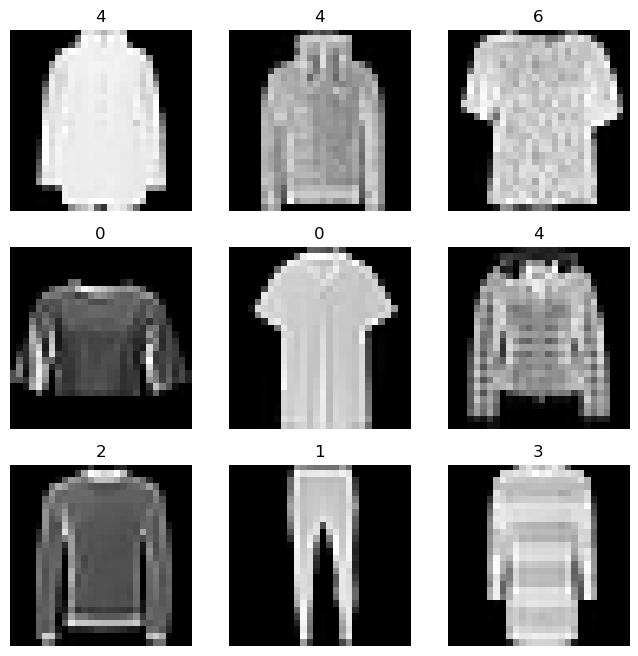

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_valid_dataset), size=(1,)).item()
    img, label = train_valid_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In deep learning, it is usual to divide the training dataset into three datasets: train, validation and test. The former is used to update the weights of the model; the second one is used to check the performance of our model during the training stage whereas the later is used to test the accuracy of the model with unseen samples. 

In our case, the Fashion-MNIST dataset consists only on a training and a test files so we are going to create a validation dataset from the training data with a 20% of the samples in this dataset.

In [5]:
VALID_RATIO = 0.2

num_train = int((1.0 - VALID_RATIO) * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train

print(f"Number of samples: training = {num_train} | validation = {num_valid}")

train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [num_train, num_valid])


Number of samples: training = 48000 | validation = 12000


### Step 2: Model architecture
In the second step, we are going to define the model architecture. 
We are going to start with a toy cnn with only a convolutional layer and two fully connected layers. In torch, the net is a subclass of `nn.Module`. The architecture is declared in the constructor of the class and the way the samples are feeded to the net is defined in the `forward` method:

In [6]:
import torch.nn as nn

class ToyCNN(nn.Module):

    def __init__(self):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=32*12*12, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        # Flatten output of the previous conv layer to feed the next fc layer
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out



**Important**: This net is adapted to the Fashion-MNIST image size. The input size of the first fully connected layer depends on the size of the previous layer. In order to compute the output size of a convolutional or a pooling layer, take into account the following equation:

$output\_size = \dfrac{input\_size + 2 * padding - kernel\_size}{stride} + 1$

### Step 3: train the model

The last step is training the model with the provided samples. The following function trains  a convolutional neural network **one epoch** with the train and validation datasets: the weights are updated using the training samples and the loss is computed in the validation dataset.

In [7]:
def train(model, loader, f_loss, optimizer, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets.long())

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss/count, correct /count  


The following code trains the `ToyCNN` model one epoch using the `CrossEntropyLoss` as function loss and the `Adam` optimizer:

In [8]:
from torch.optim import Adam

model = ToyCNN()
model.to(device)

batch_size = 64
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

loss, acc = train(model, train_loader, f_loss, optimizer, device)
torch.save(model, 'trained-model.pt')
print(f"Epoch 1 (training): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (training): Loss = 3.146389579355717 | Accuracy = 0.806375


The following function computes the predictions so we can use it to check the performance of our model in the validation dataset:

In [9]:
def test(model, loader, f_loss, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.eval()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets.long())

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

    return total_loss/count, correct /count  


In [10]:
loss, acc = test(model, valid_loader, f_loss, device)
print(f"Epoch 1 (validation): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (validation): Loss = 1.6837610617478689 | Accuracy = 0.8329166666666666


#### Exercise
Write a function that trains the model for a given number of epochs. The function should output both validation loss and accuracy for each epoch. It should also save the model with the lowest validation error during the training stage and plot both the validation loss and accuracy through epochs. 

In [11]:
def train_model(model, train_dataset, valid_dataset, device,
                optimizer, 
                loss,
                batch_size=128, 
                num_epochs=20,
                output_filename='trained-model.pt'):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    
    ### Write your code here

            
    

In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model(model, train_dataset, valid_dataset, device, optimizer, loss_fn, batch_size=128, num_epochs=20, output_filename='trained-model.pt'):

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
    
    train_losses = []
    valid_losses = []
    valid_accuracies = []
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets.long())
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss /= len(train_dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        epoch_valid_loss = 0
        epoch_valid_correct = 0
        
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, targets.long())
                
                epoch_valid_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                epoch_valid_correct += (predicted == targets).sum().item()
        
        epoch_valid_loss /= len(valid_dataset)
        valid_losses.append(epoch_valid_loss)
        valid_accuracy = epoch_valid_correct / len(valid_dataset)
        valid_accuracies.append(valid_accuracy)
        
        if epoch_valid_loss < best_valid_loss:
            torch.save(model, output_filename)
            best_valid_loss = epoch_valid_loss
            
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
        
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(valid_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

Epoch 1/20, Training Loss: 0.7536, Validation Loss: 1.0639, Validation Accuracy: 0.8504
Epoch 2/20, Training Loss: 0.5548, Validation Loss: 0.6873, Validation Accuracy: 0.8753
Epoch 3/20, Training Loss: 0.4842, Validation Loss: 0.7451, Validation Accuracy: 0.8664
Epoch 4/20, Training Loss: 0.4120, Validation Loss: 0.7065, Validation Accuracy: 0.8626
Epoch 5/20, Training Loss: 0.3637, Validation Loss: 0.6236, Validation Accuracy: 0.8731
Epoch 6/20, Training Loss: 0.3161, Validation Loss: 0.5786, Validation Accuracy: 0.8774
Epoch 7/20, Training Loss: 0.2794, Validation Loss: 0.5800, Validation Accuracy: 0.8768
Epoch 8/20, Training Loss: 0.2626, Validation Loss: 0.6321, Validation Accuracy: 0.8633
Epoch 9/20, Training Loss: 0.2486, Validation Loss: 0.6598, Validation Accuracy: 0.8538
Epoch 10/20, Training Loss: 0.2275, Validation Loss: 0.6819, Validation Accuracy: 0.8558
Epoch 11/20, Training Loss: 0.2158, Validation Loss: 0.5730, Validation Accuracy: 0.8747
Epoch 12/20, Training Loss: 0.

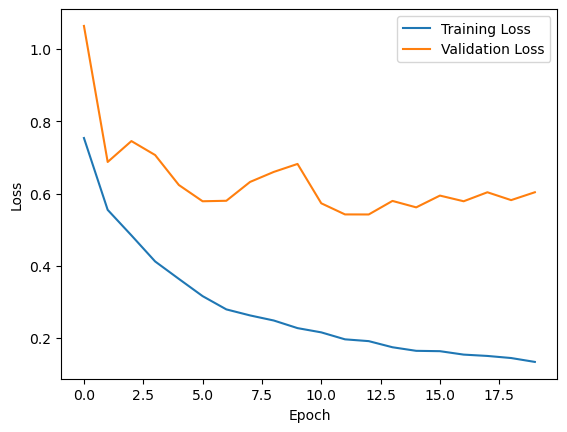

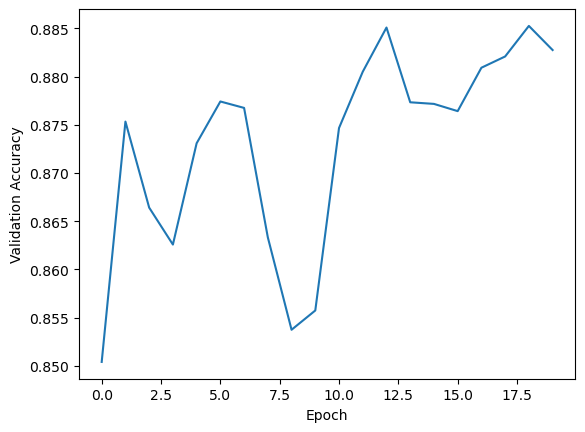

In [13]:
# IMPORTANT: adapt the batch size to your hardware requirements! 
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128, 20)

#### Exercise
Compute the success rate in the test dataset by loading the best model that have been saved.

In [14]:
model = torch.load('trained-model.pt', map_location=device)
model.to(device)

### Write your code here
def test_model(model, test_dataset, device, batch_size=128):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == labels).sum().item()
            num_samples += labels.size(0)
    accuracy = num_correct / num_samples
    print(f'Test accuracy: {accuracy:.2%}')


# Test the model on the test dataset
test_model(model, test_dataset, device)



Test accuracy: 88.86%


#### Exercise
Define another model architecture with two convolutional layers and three fully connected layers. Train the model and test the accuracy in the test dataset.

**Hint**: increase the learning rate (e.g. 0.001)

In [15]:
class FashionMNISTCNN(nn.Module):

    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = None
        self.conv2 = None
        
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None


    def forward(self, x):
        out = x
        return out


In [23]:
class FashionMNISTCNN(nn.Module):

    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        out = self.relu4(out)
        out = self.fc3(out)
        return out

Epoch 1/20, Training Loss: 0.6918, Validation Loss: 0.4143, Validation Accuracy: 0.8493
Epoch 2/20, Training Loss: 0.3729, Validation Loss: 0.3837, Validation Accuracy: 0.8582
Epoch 3/20, Training Loss: 0.3212, Validation Loss: 0.3689, Validation Accuracy: 0.8653
Epoch 4/20, Training Loss: 0.2897, Validation Loss: 0.3790, Validation Accuracy: 0.8598
Epoch 5/20, Training Loss: 0.2630, Validation Loss: 0.3675, Validation Accuracy: 0.8681
Epoch 6/20, Training Loss: 0.2514, Validation Loss: 0.3570, Validation Accuracy: 0.8762
Epoch 7/20, Training Loss: 0.2378, Validation Loss: 0.3698, Validation Accuracy: 0.8721
Epoch 8/20, Training Loss: 0.2283, Validation Loss: 0.3534, Validation Accuracy: 0.8802
Epoch 9/20, Training Loss: 0.2232, Validation Loss: 0.3549, Validation Accuracy: 0.8808
Epoch 10/20, Training Loss: 0.2014, Validation Loss: 0.3995, Validation Accuracy: 0.8775
Epoch 11/20, Training Loss: 0.1928, Validation Loss: 0.3879, Validation Accuracy: 0.8827
Epoch 12/20, Training Loss: 0.

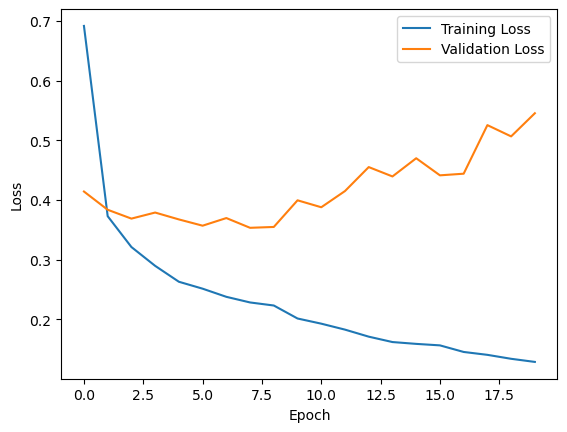

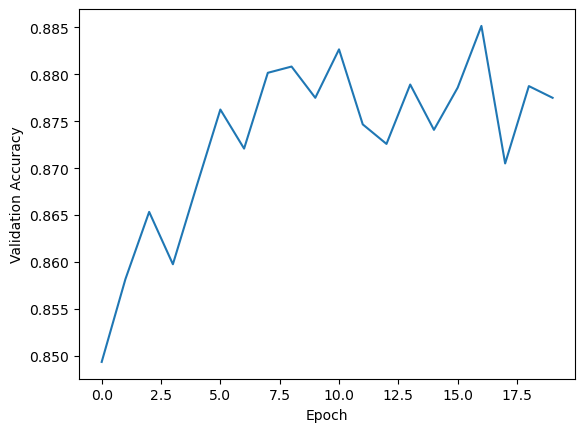

FashionMNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
model = FashionMNISTCNN()
model.to(device)

optimizer=Adam(model.parameters(), lr=0.001)

train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128, 20, 'trained-model-v2.pt')
model = torch.load('trained-model-v2.pt', map_location=device)
model.to(device)


In [25]:
## Write your code here
# Compute accuracy in the test dataset
test_model(model, test_dataset, device)

Test accuracy: 88.44%


#### Exercise
Replicate the previous architecture but include [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) before the ReLU layer and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) between two consecutive fully conected layers. Train the  model and check if these strategies have improved the accuracy in the test dataset.

In [19]:
class FashionMNISTv2CNN(nn.Module):

    def __init__(self):
        super(FashionMNISTv2CNN, self).__init__()
        self.conv1 = None
        self.conv2 = None

        self.fc1 = None
        self.drop = None
        self.fc2 = None
        self.fc3 = None


    def forward(self, x):
        out = x
        return out


In [20]:
import torch.nn as nn

class FashionMNISTv2CNN(nn.Module):
    def __init__(self):
        super(FashionMNISTv2CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=64*4*4, out_features=600)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=300)
        self.fc3 = nn.Linear(in_features=300, out_features=10)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

Epoch 1/20, Training Loss: 0.5019, Validation Loss: 0.3515, Validation Accuracy: 0.8690
Epoch 2/20, Training Loss: 0.3411, Validation Loss: 0.3441, Validation Accuracy: 0.8752
Epoch 3/20, Training Loss: 0.2973, Validation Loss: 0.3217, Validation Accuracy: 0.8814
Epoch 4/20, Training Loss: 0.2675, Validation Loss: 0.2943, Validation Accuracy: 0.8900
Epoch 5/20, Training Loss: 0.2424, Validation Loss: 0.2697, Validation Accuracy: 0.9015
Epoch 6/20, Training Loss: 0.2226, Validation Loss: 0.2997, Validation Accuracy: 0.8903
Epoch 7/20, Training Loss: 0.2038, Validation Loss: 0.2620, Validation Accuracy: 0.9067
Epoch 8/20, Training Loss: 0.1875, Validation Loss: 0.2808, Validation Accuracy: 0.9038
Epoch 9/20, Training Loss: 0.1743, Validation Loss: 0.2619, Validation Accuracy: 0.9093
Epoch 10/20, Training Loss: 0.1636, Validation Loss: 0.2937, Validation Accuracy: 0.9032
Epoch 11/20, Training Loss: 0.1503, Validation Loss: 0.2703, Validation Accuracy: 0.9114
Epoch 12/20, Training Loss: 0.

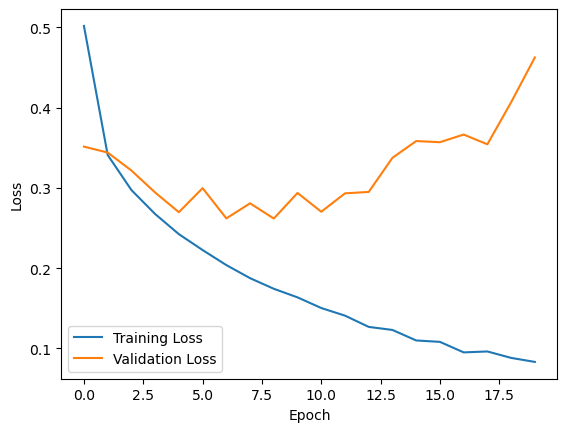

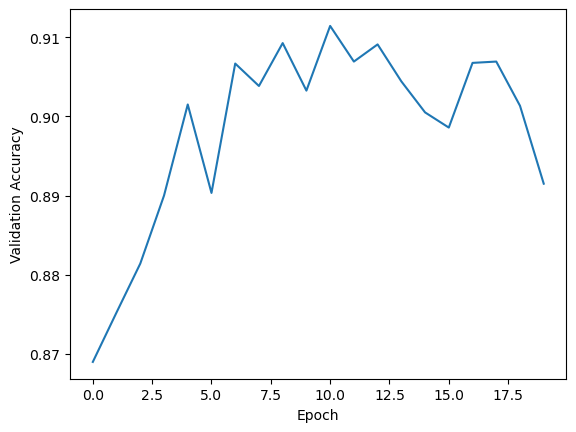

FashionMNISTv2CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1024, out_features=600, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=10, bias=True)
)

In [21]:
model = FashionMNISTv2CNN()
model.to(device)

optimizer=Adam(model.parameters(), lr=0.001)

train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128, 20, 'trained-model-v3.pt')
model = torch.load('trained-model-v3.pt', map_location=device)
model.to(device)

In [22]:
# Compute accuracy in the test dataset
test_model(model, test_dataset, device)

Test accuracy: 91.30%


Clearly the obtained results are better for the architecture that includes batch normalization and dropout.